# Modeling Traffic Delay Severity Caused by Accidents: A Machine Learning Approach

#### Final Submission - group MELY: 
- Eduard Aguado (176199), 
- Marco Sburlino (176186), 
- Luca Giovanni Gudi (175880)
- David Yoshio Uraji (175879).

### Data Pre-processing

In [76]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("data/US_Accidents_March23.csv")

def inspect_data(df):
    """
    Function to inspect the dataset
    """
    print(df.head())
    print(df.info())
    print(df.describe())

inspect_data(df)

    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          F

Dropping columns and rows

In [ ]:
def check_single_category_columns(df):
    """
    Function to check which columns have only one category.
    """
    single_category_columns = [] # We initialize an empty list to store column names
    for column in df.columns: # We iterate over each column
        if df[column].nunique() == 1: # We check if the column has only one unique value
            single_category_columns.append(column) # We add it to our list if it's single-category
    return single_category_columns # We return the list of single-category columns


def drop_missing_rows(df, rows_to_drop):
    """
    Function to drop rows with missing values from certain columns
    """
    for column in rows_to_drop: # We go through each specified column
        if column in df.columns:
            df.dropna(subset=[column], inplace=True) # We drop rows inplace where this column has missing values
        else:
            print(f"Missing values for column {column} not found.")
    return df # We return the cleaned DataFrame.


def drop_columns(df, columns_to_drop):
    """
    Function to drop unnecessary columns from the dataset
    """
    for column in columns_to_drop: # We iterate through each column in the list
        if column in df.columns:
            df.drop(column, axis=1, inplace=True) # We drop it from the df
        else:
            print(f"Column {column} not found.")
    return df


irrelevant_columns = ["Source", "Start_Lng", "Start_Lat", "End_Lat", "End_Lng", "End_Time", "Description", "Street", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Direction", "Wind_Chill(F)",  "Weather_Condition", "Sunrise_Sunset", "Astronomical_Twilight", "Nautical_Twilight"]

df = drop_columns(df, irrelevant_columns) # We drop irrelevant columns
df = drop_columns(df, check_single_category_columns(df)) # We drop columns with only one category (e.g. "Country" = USA for all columns)
df = df.drop_duplicates() # We also drop duplicates to ensure that each row is unique

rows_to_drop =["City", "Zipcode", "Civil_Twilight"]
df = drop_missing_rows(df, rows_to_drop) # We drop rows with missing values in these columns

Fill the missing values for precipitation and wind speed with 0 since the null values indicate no precipitation or wind speed as explained in the dataset overview

In [ ]:
def fill_missing_values(df, column, value):
    """
    Function to fill missing values in a column with a specific value
    """
    if column in df.columns:
        df[column] = df[column].fillna(value) # We fill missing values with the specified default
    return df

df = fill_missing_values(df, "Precipitation(in)", 0)
df = fill_missing_values(df, "Wind_Speed(mph)", 0)

In [ ]:
df["Severity"] = df["Severity"].astype("category") # We convert column datatypes: severity to category

missing_values = df.isnull().sum()
print("Columns with Missing Values:\n")
print(missing_values[missing_values > 0]) # We display only those columns that still have missing values.

Columns with Missing Values:

Temperature(F)    159081
Humidity(%)       169322
Pressure(in)      135943
Visibility(mi)    172282
dtype: int64


### EDA

Plot the distribution of severity

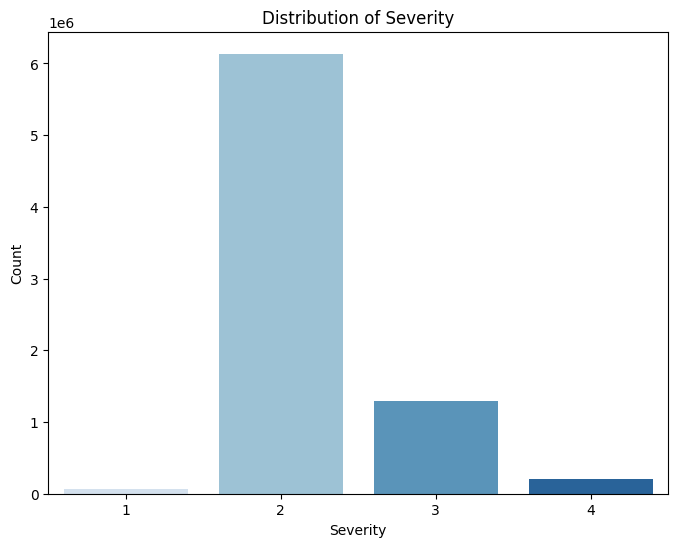

In [ ]:
gradient_pallete = sns.color_palette("Blues", n_colors=df["Severity"].nunique()) # We set a gradient palette to be consistent with the number of severity levels

def plot_distribution(data, col = None, title = "", pallete="Set2"):
    """
    Function to plot the distribution of a target column
    """
    plt.figure(figsize=(8, 6))
    
    if isinstance(data, pd.Series): # We check if the input is a single Series
        sns.countplot(x=data, hue=data, palette=pallete, legend=False)
        plt.xlabel(data.name if data.name else "Value")
    else:
        sns.countplot(data=data, x=col, hue=col, palette=pallete, legend=False) # We do the same when data is a full DataFrame
        plt.xlabel(col)

    plt.title(title)
    plt.ylabel("Count")
    plt.show()

plot_distribution(data=df, col="Severity", title="Distribution of Severity", pallete=gradient_pallete)

Plot distribution of numerical columns

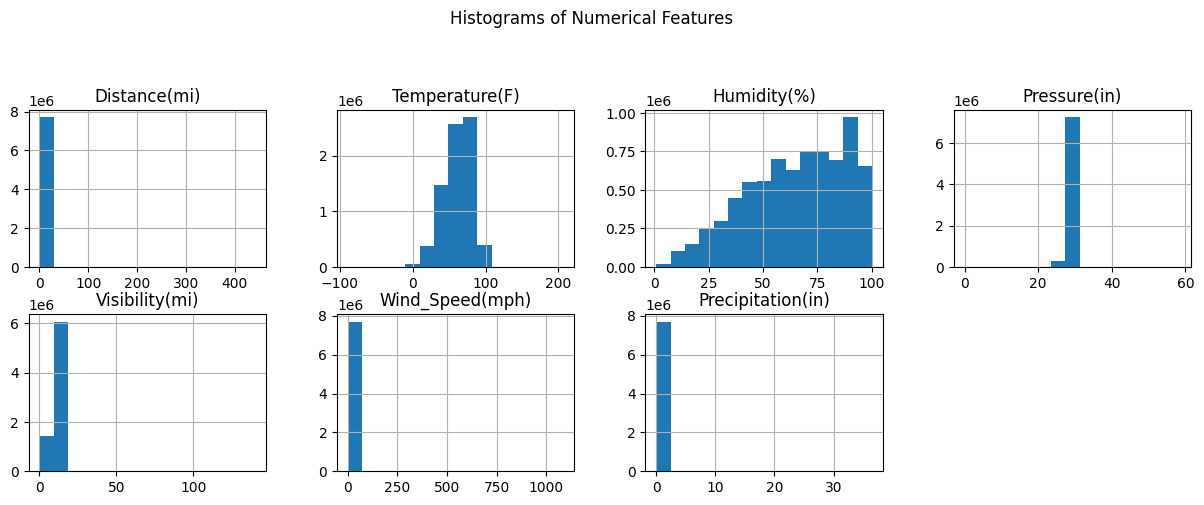

<Figure size 1500x800 with 0 Axes>

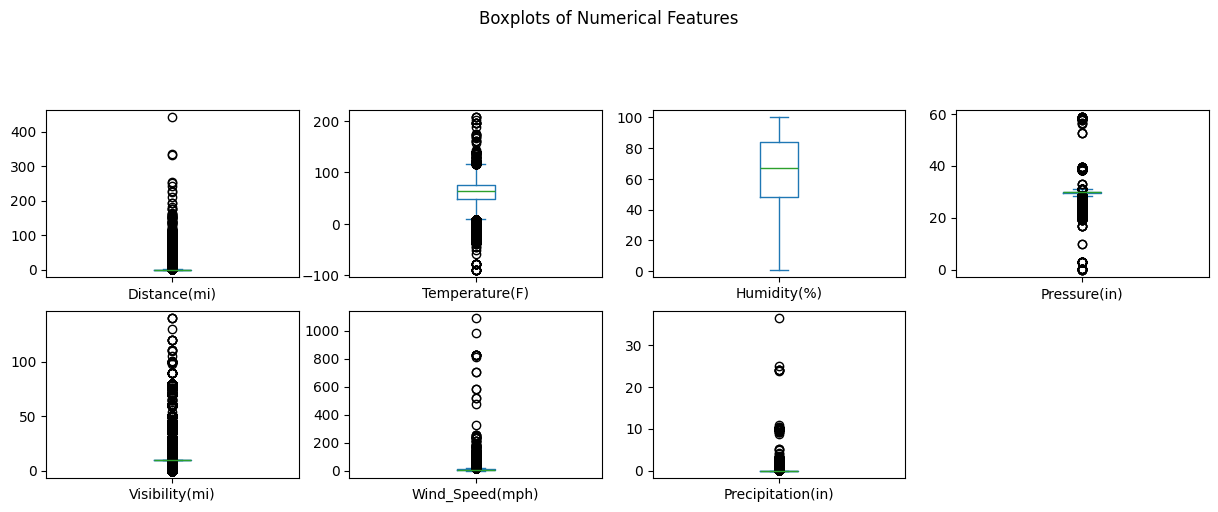

In [ ]:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns # We select only numerical columns to analyze their distributions and outliers

def numerical_columns_distribution(df, cols):
    """
    Function to plot histograms of numerical columns distributions
    """
    df[cols].hist(bins=15, figsize=(15, 10), layout=(4, 4))
    plt.suptitle("Histograms of Numerical Features")
    plt.show()


def numerical_columns_outliers(df, cols):
    """
    Function to plot boxplots of numerical columns to check for outliers
    """
    plt.figure(figsize=(15, 8))
    df[numerical_cols].plot(kind="box", subplots=True, layout=(4, 4), figsize=(15, 10), sharex=False, sharey=False)
    plt.suptitle("Boxplots of Numerical Features")
    plt.show()


numerical_columns_distribution(df, numerical_cols) # We plot histograms to get an overview of feature distributions
numerical_columns_outliers(df, numerical_cols) # We plot boxplots to identify and later handle outliers

We Remove the outliers using the IQR method

In [ ]:
def remove_outliers_iqr(df, columns):
    """
    Removes outliers from a DataFrame based on the IQR method.
    """
    df_clean = df.copy() # We create a copy so we don’t modify the original DataFrame
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1 # We compute the interquartile range to be able to identify outliers
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)] # We filter out the rows with outliers
        print(f"Outliers removed from {col}: {len(df) - len(df_clean)}") # We display how many rows were removed per column
    
    return df_clean

outlier_cols = ["Distance(mi)", "Temperature(F)", "Pressure(in)", "Humidity(%)", "Wind_Speed(mph)"]
df = remove_outliers_iqr(df, outlier_cols)  # We apply the IQR method only to the columns we want to clean
print(df.shape)

Outliers removed from Distance(mi): 962180
Outliers removed from Temperature(F): 1146562
Outliers removed from Pressure(in): 1519684
Outliers removed from Humidity(%): 1527643
Outliers removed from Wind_Speed(mph): 1662322
(6040952, 27)


We plot everything again to check the changes in the distributions

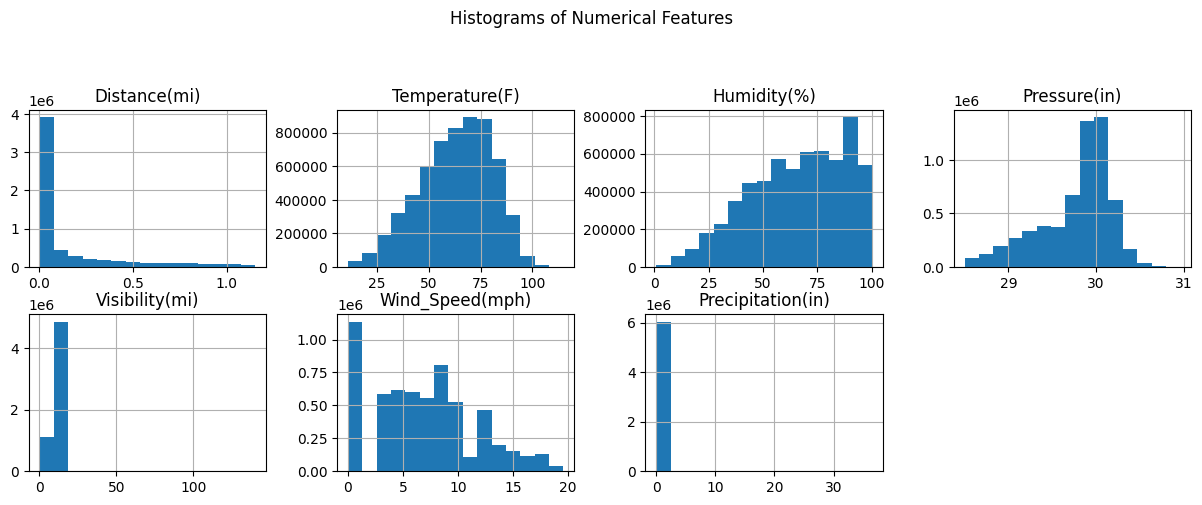

<Figure size 1500x800 with 0 Axes>

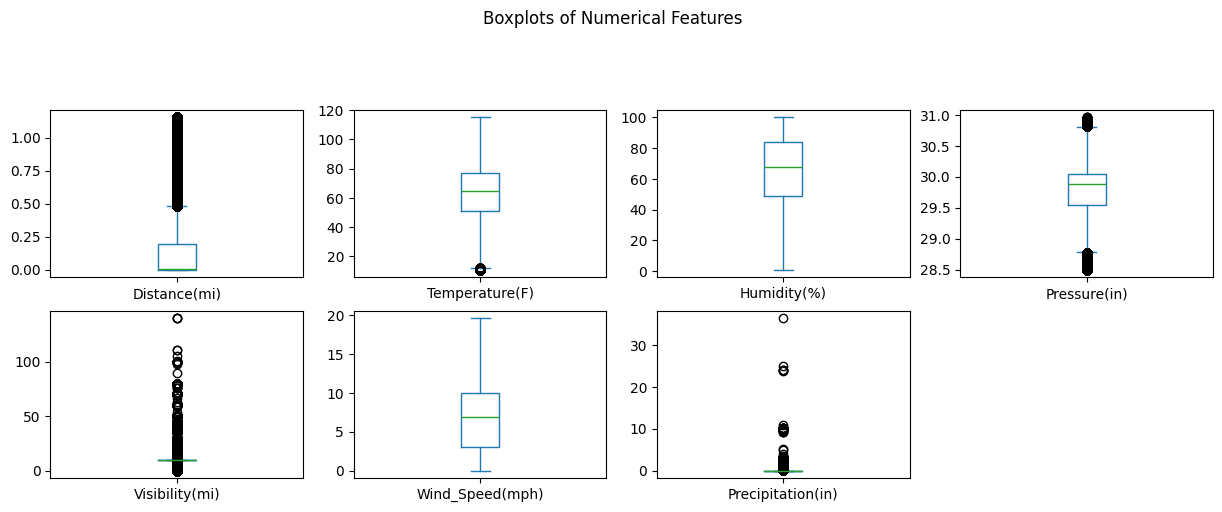

In [ ]:
# We plot the distributions and outliers again to see the effect of the IQR method
numerical_columns_distribution(df, numerical_cols)
numerical_columns_outliers(df, numerical_cols)

Plot the correlation matrix but no covariance since coviariance is then unnecessary

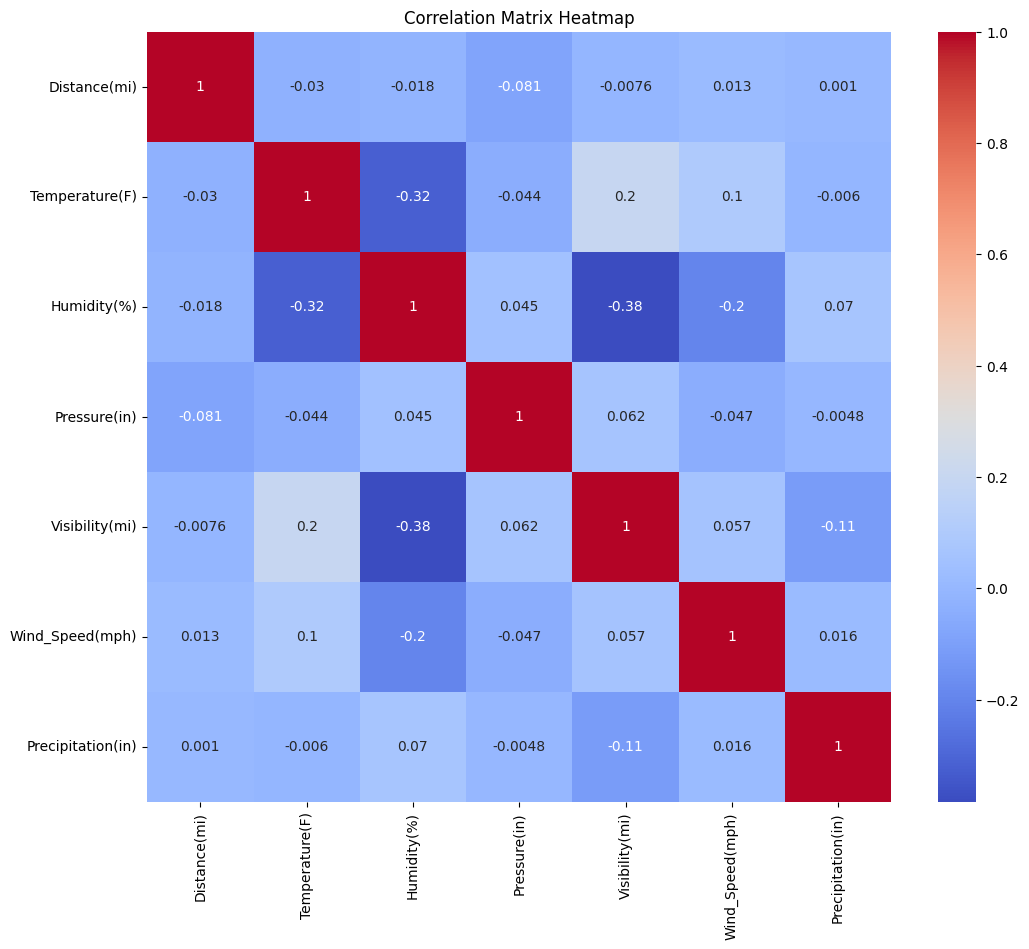

In [ ]:
def plot_correlation_matrix(df, excluded_columns=None):
    """
    Function to plot the correlation matrix
    """
    if excluded_columns is None:
        excluded_columns = [] # We initialize the list of excluded columns if not provided
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=excluded_columns, errors="ignore") # We focus only on numerical features, skipping irrelevant ones like dates
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

columns_to_exclude = ["Year", "Month", "Weekday", "Hour"] # We exclude columns that are not relevant for correlation analysis
plot_correlation_matrix(df, excluded_columns=columns_to_exclude)

### Data Preparation

Import necessary libraries

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler

Freatures Engineering

In [ ]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="mixed") # We convert Start_Time to datetime to extract meaningful temporal features

# Create time-based features
df["Hour"] = df["Start_Time"].dt.hour
df["DayOfWeek"] = df["Start_Time"].dt.dayofweek
df["Month"] = df["Start_Time"].dt.month
df["Year"] = df["Start_Time"].dt.year

# Map each month to a corresponding season
df["Season"] = df["Month"].apply(lambda x: "Winter" if x in [12, 1, 2] 
                                  else "Spring" if x in [3, 4, 5]
                                  else "Summer" if x in [6, 7, 8] 
                                  else "Fall")

df = pd.get_dummies(df, columns=["Season"], drop_first=True) # We one-hot encode the season variable and drop one to avoid multicollinearity

# Convert Civil Twilight info into a binary Daylight flag
df["Daylight"] = df["Civil_Twilight"].apply(lambda x: True if x == "Day" else False)
df.drop(columns=["Civil_Twilight"], inplace=True)

# Ensure selected features are boolean
boolean_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction",
    "No_Exit", "Railway", "Roundabout", "Station", "Stop",
    "Traffic_Calming", "Traffic_Signal", "Daylight"
]
df[boolean_cols] = df[boolean_cols].astype(bool)

# One-Hot Encode the States
df = pd.get_dummies(df, columns=["State"], drop_first=True)

# Create Severity Grouped and cast to category. We do this to reduce the number of classes in the target variable
df["Severity_Grouped"] = df["Severity"].apply(lambda x: 0 if int(x) in [1, 2] else 1).astype("category")
df.drop(columns=["Severity"], inplace=True)

# Drop NaNs if any remain
df.dropna(inplace=True)

Dataset split

In [ ]:
X = df.drop(columns=["Severity_Grouped", "Start_Time", "ID", "Zipcode", "City", "County"])
y = df["Severity_Grouped"]

# Stratified sampling to get exactly 630k test set, we do this because later we are going to use Undersampling techniques to deal with the class imbalance and we want it to be approximately 20% of the training set
sss = StratifiedShuffleSplit(n_splits=1, test_size=630000, random_state=42)

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test_final = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (5380261, 75), Test set: (630000, 75)


Plot the distribution of Severity_Grouped

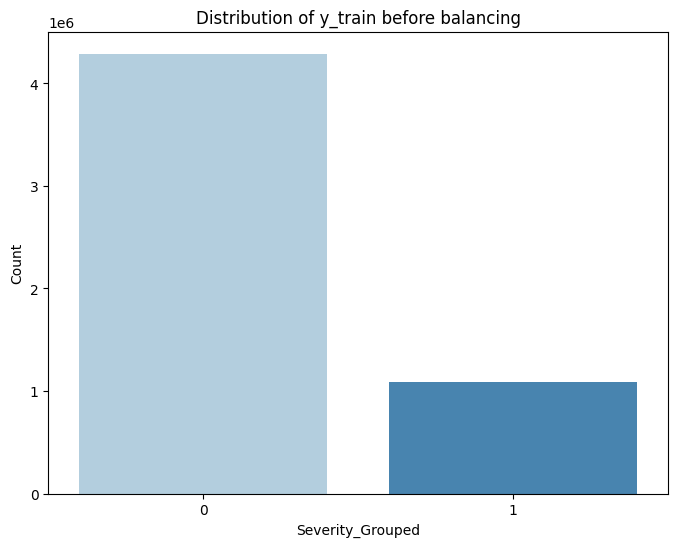

Severity Distribution:
Severity_Grouped
0    4290553
1    1089708
Name: count, dtype: int64


In [ ]:
gradient_pallete = sns.color_palette("Blues", n_colors=df["Severity_Grouped"].nunique()) # We set a gradient palette to be consistent with the colors

plot_distribution(data=y_train, title="Distribution of y_train before balancing", pallete=gradient_pallete) # We plot the class imbalance in training set
print("Severity Distribution:")
print(y_train.value_counts())

Pipelines setup and Undersampling

In [ ]:
# Separate numeric and boolean columns for preprocessing
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
boolean_cols = X_train.select_dtypes(include=["bool"]).columns

X_train = X_train.copy()
X_test = X_test.copy()

# We convert booleans to integers for compatibility with modeling
X_train[boolean_cols] = X_train[boolean_cols].apply(lambda col: col.astype("int8")) 
X_test[boolean_cols] = X_test[boolean_cols].apply(lambda col: col.astype("int8"))

# Define Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")), # We fill missing values in numeric features with the mean
    ("scaler", StandardScaler()) # We scale numerical features
])

boolean_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")) # We fill missing values in boolean features with the most frequent value
])

# Combine preprocessing steps for both numeric and boolean features
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("bool", boolean_transformer, boolean_cols)
])

# Apply Preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Perform undersampling to balance the classes in the training data
undersampler = RandomUnderSampler(sampling_strategy={0: 1900000}, random_state=42) # We keep 1.9M from class 0 and all from class 1
X_train_final, y_train_final = undersampler.fit_resample(X_train_transformed, y_train) # We apply the undersampling strategy
X_test_final = X_test_transformed # We keep the full test set untouched in order to preserve real-world distribution

Plot the final training distribution after balancing

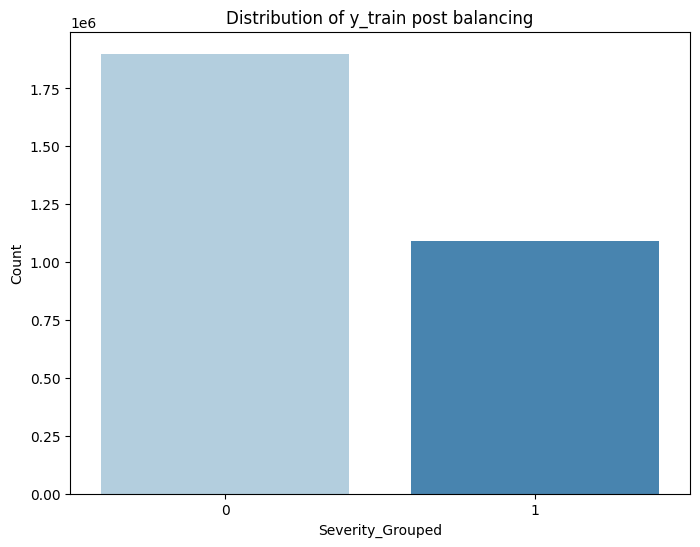

Balanced Severity Distribution:
Severity_Grouped
0    1900000
1    1089708
Name: count, dtype: int64


In [ ]:
gradient_pallete = sns.color_palette("Blues", n_colors=df["Severity_Grouped"].nunique())

plot_distribution(data=y_train_final, title="Distribution of y_train post balancing", pallete=gradient_pallete)
print("Balanced Severity Distribution:")
print(y_train_final.value_counts()) # We print the new class counts after balancing

### Baseline Model
Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score


logreg = LogisticRegression(random_state=42, max_iter=1000) # We initialize a Logistic Regression model with a fixed random state and a higher max_iter to ensure convergence
logreg.fit(X_train_final, y_train_final) # We train the model using the balanced training data

y_pred_logit = logreg.predict(X_test_final) # We generate predictions on the test set

In [ ]:
def print_metrics(y_true, y_pred):
    """
    Function to print evaluation metrics
    """
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3)) # We evaluate overall correctness
    print("Precision:", round(precision_score(y_true, y_pred), 3)) # We evaluate how many predicted positives are truly positive
    print("Recall:", round(recall_score(y_true, y_pred), 3)) # We evaluate how many actual positives were correctly predicted
    print("F1-score:", round(f1_score(y_true, y_pred, average="weighted"), 3)) # We calculate the harmonic mean of precision and recall, weighted by support
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred)) # We display the confusion matrix to inspect TP, TN, FP, FN
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred)) # We get a detailed breakdown of precision, recall, and F1 per class

print_metrics(y_test_final, y_pred_logit)

Accuracy: 0.772
Precision: 0.435
Recall: 0.413
F1-score: 0.77

Confusion Matrix:
[[433743  68658]
 [ 74844  52755]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86    502401
           1       0.43      0.41      0.42    127599

    accuracy                           0.77    630000
   macro avg       0.64      0.64      0.64    630000
weighted avg       0.77      0.77      0.77    630000



We now train the final model on the full dataset

### Hist Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

# We define the initial HistGradientBoostingClassifier model with class_weight="balanced" to address class imbalance by weighting classes to their frequency
hgb_model = HistGradientBoostingClassifier(
    class_weight="balanced",
    early_stopping=False, # We set early_stopping=False for now because early stopping conflicts with cross-validation during tuning
    random_state=42
)

# We use StratifiedKFold to preserve the class distribution across folds during cross-validation. We choose 3 splits and shuffle the data before splitting for randomness
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We define the hyperparameter search space for tuning
param_grid = { 
    "learning_rate": [0.05, 0.1], # We control the learning rate for gradient boosting, lower values train slower but reduce risk of overfitting
    "max_iter": [100, 200], # We define the number of boosting iterations (trees)
    "max_leaf_nodes": [31, 63], # We control the model complexity by limiting the number of leaf nodes per tree
    "max_depth": [5, 10], # We limit the maximum depth of individual trees to prevent overfitting
    "min_samples_leaf": [50, 100], # We increase the minimum samples per leaf to regularize the model and smooth out predictions
    "l2_regularization": [0.0, 1.0, 10.0], # We explore different levels of L2 regularization to penalize large weights and control overfitting
}

# We use HalvingRandomSearchCV for efficient hyperparameter search. Halving progressively eliminates worse performing parameter sets and allocates more resources to promising ones
random_search = HalvingRandomSearchCV(
    estimator=hgb_model,
    param_distributions=param_grid,
    factor=3, # We use a factor of 3 to aggressively reduce the candidate pool in each iteration
    cv=cv,
    scoring="f1_weighted", # We optimize for the weighted F1-score to balance performance across imbalanced classes
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit and retrieve best model
random_search.fit(X_train_final, y_train_final)
print("\nBest Parameters Found:", random_search.best_params_)

# We now keep the final model using the best hyperparameters and re-enable early stopping, which helps prevent overfitting. validation_fraction=0.1 means 10% of the training data is used as a validation set for early stopping
final_model = HistGradientBoostingClassifier(
    **random_search.best_params_,
    class_weight="balanced",
    early_stopping=True,
    n_iter_no_change=10, # We stop training if there’s no improvement for 10 rounds
    validation_fraction=0.1,
    random_state=42
)

final_model.fit(X_train_final, y_train_final) # We train the final model using the full training data

c:\Users\marco\OneDrive\Desktop\MSc Data Science\Machine Learning and Deep Learning\Final Assignment\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 96 is smaller than n_iter=249142. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best Parameters Found: {'min_samples_leaf': 50, 'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 10.0}


HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               l2_regularization=10.0, max_depth=10,
                               max_iter=200, min_samples_leaf=50,
                               random_state=42)

Prediction

In [ ]:
def print_metrics(model, X, y, name="Set"):
    """
    Function to print evaluation metrics for a model
    """
    y_pred = model.predict(X) # We generate predicted labels for X (either train or test set)

    # We try to get probabilities if the model supports it (used for ROC AUC)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X)
    else:
        y_proba = None

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba) if y_proba is not None else "N/A"

    print(f"\n=== {name} Set Performance ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")                                                               
    print(f"ROC AUC:   {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

In [95]:
# Run evaluations
print_metrics(final_model, X_train_final, y_train_final, name="Train")
print_metrics(final_model, X_test_final, y_test_final, name="Test")


=== Train Set Performance ===
Accuracy:  0.7435
Precision: 0.6149
Recall:    0.7933
F1-score:  0.6928
ROC AUC:   0.8291

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78   1900000
           1       0.61      0.79      0.69   1089708

    accuracy                           0.74   2989708
   macro avg       0.74      0.75      0.74   2989708
weighted avg       0.77      0.74      0.75   2989708

Confusion Matrix:
[[1358537  541463]
 [ 225282  864426]]

=== Test Set Performance ===
Accuracy:  0.7308
Precision: 0.4143
Recall:    0.7945
F1-score:  0.5446
ROC AUC:   0.8291

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81    502401
           1       0.41      0.79      0.54    127599

    accuracy                           0.73    630000
   macro avg       0.67      0.75      0.68    630000
weighted avg       0.83      0.73      0.76    630000



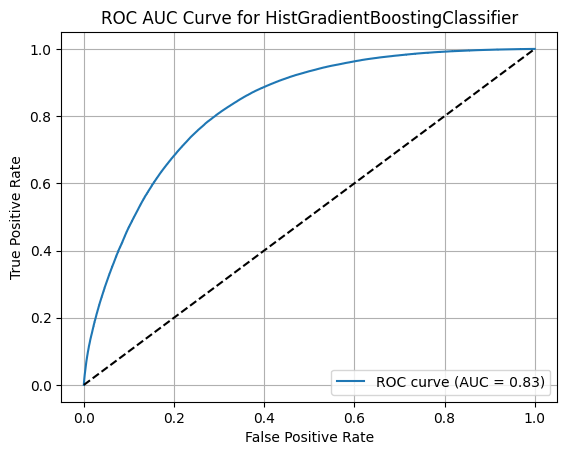

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_hgb = final_model.predict_proba(X_test_final)[:, 1] # We get predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test_final, y_prob_hgb) # We compute False Positive Rate and True Positive Rate for ROC
auc_score = roc_auc_score(y_test_final, y_prob_hgb) # We calculate the AUC

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve for HistGradientBoostingClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# We convert the training data into pandas objects in case they are NumPy arrays (mainly done for sampling)
X_train_df = pd.DataFrame(X_train_final)
y_train_series = pd.Series(y_train_final)

# We sample 50% of the training set to speed up hyperparameter tuning while still keeping enough examples for stability
X_sample = X_train_df.sample(frac=0.50, random_state=42) 
y_sample = y_train_series.loc[X_sample.index]

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42) # We define the base Random Forest model, with class_weight="balanced" to automatically adjust weights

param_grid = {
    "n_estimators": randint(100, 150), # We limit the number of trees to keep training efficient while still allowing depth
    "max_depth": randint(10, 18), # We explore a range of tree depths to balance bias and variance
    "min_samples_split": randint(2, 6), # We control how many samples are needed to split an internal node
    "min_samples_leaf": randint(3, 6), # We force each leaf to have more samples to regularize the tree and prevent overfitting
    "bootstrap": [True], # We enable bootstrapping (bagging), which improves generalization by training each tree on a random subset
    "max_features": ["sqrt", "log2"] # We try different strategies for the number of features to consider at each split
}

# We use StratifiedKFold to ensure that each fold maintains the same class proportions. We choose only 2 splits to reduce training time during hyperparameter search
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# We perform a randomized hyperparameter search using 12 iterations. Also in this case we use f1_weighted as the scoring metric to account for class imbalance.
search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=12,
    scoring="f1_weighted",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=2 # We use n_jobs=2 to parallelize training across 2 CPU cores without overloading the system
)

print("Starting hyperparameter optimization...")
search.fit(X_sample, y_sample)
print("Hyperparameter optimization complete!")
print("Best parameters found:", search.best_params_)

# We define the final Random Forest using the best found parameters. We use max_samples=0.9 to have each tree trained on only 90% of the data, which helps reduce variance and prevent overfitting. We also enable oob_score=True to get an additional internal estimate of model performance without needing a separate validation set
best_rf_model = RandomForestClassifier(
    **search.best_params_,
    class_weight="balanced",
    max_samples=0.9,
    oob_score=True,
    random_state=42
)

Starting hyperparameter optimization...
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Hyperparameter optimization complete!
Best parameters found: {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 118}


In [97]:
print("Training the final model on the full training set...")
best_rf_model.fit(X_train_final, y_train_final)
print("Model training complete!")

Training the final model on the full training set...
Model training complete!


In [ ]:
print_metrics(best_rf_model, X_train_final, y_train_final, name="Train")
print_metrics(best_rf_model, X_test_final, y_test_final, name="Test")


=== Train Set Performance ===
Accuracy:  0.7290
Precision: 0.5985
Recall:    0.7792
F1-score:  0.6770
ROC AUC:   0.8175

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77   1900000
           1       0.60      0.78      0.68   1089708

    accuracy                           0.73   2989708
   macro avg       0.72      0.74      0.72   2989708
weighted avg       0.76      0.73      0.73   2989708

Confusion Matrix:
[[1330339  569661]
 [ 240581  849127]]

=== Test Set Performance ===
Accuracy:  0.7140
Precision: 0.3951
Recall:    0.7758
F1-score:  0.5235
ROC AUC:   0.8140

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80    502401
           1       0.40      0.78      0.52    127599

    accuracy                           0.71    630000
   macro avg       0.66      0.74      0.66    630000
weighted avg       0.82      0.71      0.74    630000



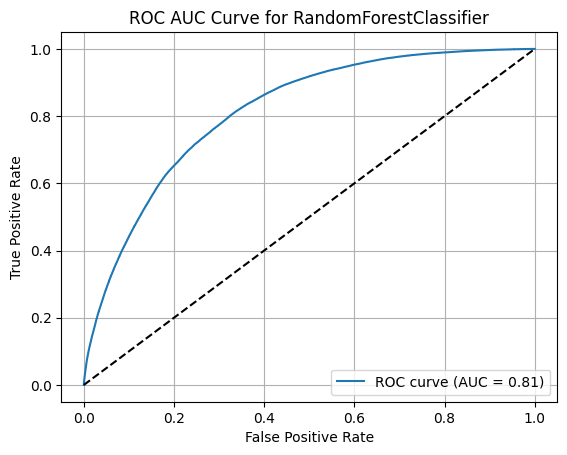

In [ ]:
y_prob_rf= best_rf_model.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_final, y_prob_rf)
auc_score = roc_auc_score(y_test_final, y_prob_rf)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve for RandomForestClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from scipy.stats import uniform

# We define the base MLPClassifier model. Even in this case we disable early stopping during the tuning phase to avoid internal validation interfering with cross-validation. We also increase max_iter to 500 to give the network more epochs to converge
mlp_model = MLPClassifier(
    max_iter=500,
    early_stopping=False,
    random_state=42
)

# Step 2: Parameter space
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25)], # We test different architectures: shallow vs. deeper networks
    'activation': ['tanh', 'relu'], # We explore both tanh (smoother) and relu (faster convergence) as activation functions
    'solver': ['adam'], # We use 'adam' which is an adaptive optimizer suitable for most tasks
    'alpha': uniform(0.0001, 0.01), # We tune the L2 regularization strength to control overfitting
    'learning_rate': ['constant', 'adaptive'] # We test whether a fixed or adaptive learning rate performs better
}

# We use stratified k-fold to preserve class balance in each fold during cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We apply HalvingRandomSearchCV to efficiently narrow down the best hyperparameter combinations
search = HalvingRandomSearchCV(
    estimator=mlp_model,
    param_distributions=param_grid,
    factor=3,
    scoring='f1_weighted',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting hyperparameter search...")
search.fit(X_train_final, y_train_final)
print("Best hyperparameters:", search.best_params_)

# After tuning, we refit the final model using early stopping to prevent overfitting. We use n_iter_no_change=10, so training stops early if performance doesn’t improve for 10 epochs. We set validation_fraction=0.1 to use 10% of the training data for monitoring during early stopping
final_mlp_model = MLPClassifier(
    **search.best_params_,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42
)

final_mlp_model.fit(X_train_final, y_train_final)
print("Final MLP model trained.")

In [ ]:
print_metrics(final_mlp_model, X_train_final, y_train_final, name="Train")
print_metrics(final_mlp_model, X_test_final, y_test_final, name="Test")


=== Train Set Performance ===
Accuracy:  0.7542
Precision: 0.6735
Recall:    0.6320
F1-score:  0.6521
ROC AUC:   0.8237

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81   1900000
           1       0.67      0.63      0.65   1089708

    accuracy                           0.75   2989708
   macro avg       0.73      0.73      0.73   2989708
weighted avg       0.75      0.75      0.75   2989708

Confusion Matrix:
[[1566099  333901]
 [ 401000  688708]]

=== Test Set Performance ===
Accuracy:  0.7849
Precision: 0.4767
Recall:    0.6330
F1-score:  0.5438
ROC AUC:   0.8229

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86    502401
           1       0.48      0.63      0.54    127599

    accuracy                           0.78    630000
   macro avg       0.69      0.73      0.70    630000
weighted avg       0.81      0.78      0.80    630000



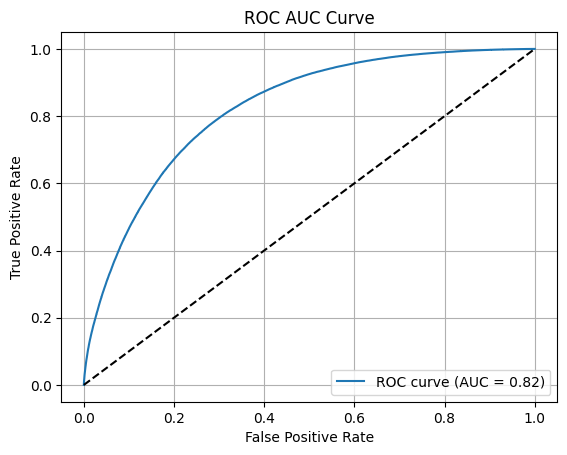

In [ ]:
y_prob_mlp = final_mlp_model.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_final, y_prob_mlp)
auc_score = roc_auc_score(y_test_final, y_prob_mlp)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()